# Complexity of community detections

Explore the complexity of community detection algorithms. Use the Boston activity data as an example. Compare

- Girvan Newman (hierarchial communities)
- Greedy modularity communities
- Naive greedy modularity communities 
- Louvain method from communities module 
- Hierarchical clustering from communities module 
- Jure Leskovec - The supervised learning approach

Resources: 
https://networkx.org/documentation/stable/reference/algorithms/community.html

Goals:

- Identify practically feasible size of graph for the algorithms.
- Understand the theoretical computational complexity.
- Provide ideas to increase the efficiency of the algorithms.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pickle 

In [2]:
import networkx.algorithms.community as nxcom

## Read and Preprocessing Data

In [3]:
with open('./data/boston_activities/raw/boston_activities.pickle', 'rb') as f:
    df = pickle.load(f)
    
print(df.shape)
print(df.columns)

(12053805, 14)
Index(['user', 'duration', 'ini_dat', 'lon_medoid', 'lat_medoid', 'GEOID',
       'home_lon_med', 'home_lat_med', 'GEOID_home', 'quant', 'fsq_id', 'cat',
       'distPOI', 'disthome'],
      dtype='object')


In [4]:
# nodes
user_nodes = list(np.unique(df.user))
geoid_nodes = list(np.unique(df.GEOID))

print(len(user_nodes))
print(len(geoid_nodes)) # the graph size is HUGE.

# edges with weights
weight_df = df.groupby(['user','GEOID']).count().iloc[:, 0].reset_index()

weight_list = []
for idx in range(weight_df.shape[0]):
    user_geoid_tuple = (weight_df.loc[idx, 'user'], weight_df.loc[idx, 'GEOID'], {'weight' : weight_df.loc[idx, 'duration']})
    weight_list.append(user_geoid_tuple)


72803
3115


In [9]:
# create a bipartite graph for people and place
# graph nodes
G = nx.Graph()
G.add_nodes_from(user_nodes, bipartite=0)
G.add_nodes_from(geoid_nodes, bipartite=1)

# graph edges
G.add_edges_from(weight_list)

# obtain two node sets.
user_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0} 
geoid_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 1} 


In [19]:
# create a graph for places only
people_place_vector = df.groupby(['user','GEOID']).count().iloc[:, 0]
people_place_m = people_place_vector.unstack(level = 'user')

# replace nan by zeros in the matrix
people_place_m.values[people_place_m.isna()] = 0.0

# matrix for the place adjacency
place_adjacency_m = np.matmul(people_place_m.values, people_place_m.values.T)


(array([9.702978e+06, 1.740000e+02, 3.900000e+01, 2.100000e+01,
        5.000000e+00, 6.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([       0. ,  2358477.4,  4716954.8,  7075432.2,  9433909.6,
        11792387. , 14150864.4, 16509341.8, 18867819.2, 21226296.6,
        23584774. ]),
 <BarContainer object of 10 artists>)

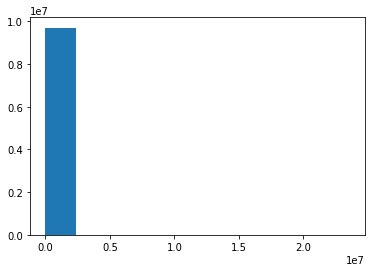

In [33]:
plt.hist(place_adjacency_m.reshape(-1))
# sw Question: How does the weight influence the community structure, particularly when the weights are quite skewed? 

In [43]:
# convert m to the adjacency matrix
place_adjacency_df = pd.DataFrame(place_adjacency_m, index = people_place_m.index, columns = people_place_m.index)

# convert float to int. Convert all non-zeros to one.
delta_ = 0.000001 
place_adjacency_df.values[ place_adjacency_df.values < delta_] = int(0)
place_adjacency_df.values[ place_adjacency_df.values > delta_] = int(1)
place_adjacency_df

GEOID,250092011001,250092021011,250092021012,250092021013,250092021021,250092021022,250092021023,250092021024,250092021025,250092022001,...,330170845001,330170845002,330170846001,330170850003,330170850004,330170870001,330170870002,330170870003,330170870004,330170880003
GEOID,,,,,,,,,,,,,,,,,,,,,
250092011001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250092021011,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
250092021012,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250092021013,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
250092021021,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330170870001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
330170870002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
330170870003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [44]:
# Create an undirected place graph without weights.
G_place = nx.from_pandas_adjacency(place_adjacency_df)

In [46]:
# Obtain place graph info. (diameter is slow to get...)
print("Is G_place fully connected?", nx.is_connected(G_place))
print("What is the density of G_place?", nx.density(G_place))
print("What is the diameter of G_place?", nx.diameter(G_place))

Is G_place fully connected? True
What is the density of G_place? 0.5500797413637577
What is the diameter of G_place? 3


Complexity of the descriptive stat varies - graph diameter is very slow $O(V^3)$ compelxity. 
The G_place is very dense. Its diameter is small.

In [60]:
# Obtain place graph info. (clustering coefficient is slow to compute)
print("What is the clustering coefficient of G_place?", nx.clustering(G_place)) # between 0 and 1.

KeyboardInterrupt: 

In [61]:
print("What is the average degree of the nodes in G_place?", np.mean(list(dict(nx.degree(G_place)).values())))

What is the average degree of the nodes in G_place? 1712.9483146067416


(array([150., 158., 184., 225., 342., 531., 572., 513., 331., 109.]),
 array([3.000e+00, 3.090e+02, 6.150e+02, 9.210e+02, 1.227e+03, 1.533e+03,
        1.839e+03, 2.145e+03, 2.451e+03, 2.757e+03, 3.063e+03]),
 <BarContainer object of 10 artists>)

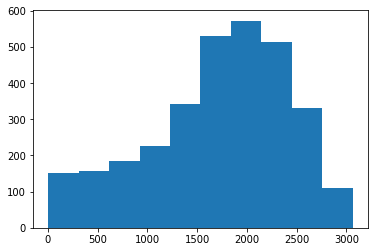

In [59]:
# Obtain place graph info - degree distribution
plt.hist(list(dict(nx.degree(G_place)).values()))

In [66]:
# save the place graph
with open('./data/boston_activities/processed/G_place.pickle', 'wb') as f:
    pickle.dump(G_place, f)


## Community detection for the place graph (a dense graph)

In [5]:
import networkx.algorithms.community as nxcom
import time

In [6]:
with open('./data/boston_activities/processed/G_place.pickle', 'rb') as f:
    G_place = pickle.load(f)
    

### 1. Greedy modularity communities

In [70]:
starting_time = time.time()
communities = sorted(nxcom.greedy_modularity_communities(G_place), key=len, reverse=True)
end_time = time.time()

In [83]:
# Analyze the greedy modularity communities
print("Greedy modularity takes", np.round(end_time - starting_time, decimals = 2), 'seconds')
print(f"The place graph has {len(communities)} communities.")
# print(communities)
for i in range(len(communities)):
    print(f"Community {i} has", len(communities[i]), 'members.')
    

Greedy modularity takes 92.29 seconds
The place graph has 5 communities.
Community 0 has 1578 members.
Community 1 has 1533 members.
Community 2 has 2 members.
Community 3 has 1 members.
Community 4 has 1 members.


### 2. Naive greedy modularity communities 

In [84]:
# no result after four hours.
starting_time = time.time()
communities = sorted(nxcom.naive_greedy_modularity_communities(G_place), key=len, reverse=True)
end_time = time.time()

KeyboardInterrupt: 

In [ ]:
# Analyze the naive greedy modularity algorithm
print("Naive greedy modularity takes", np.round(end_time - starting_time, decimals = 2), 'seconds')
print(f"The place graph has {len(communities)} communities.")
# print(communities)
for i in range(len(communities)):
    print(f"Community {i} has", len(communities[i]), 'members.')


### 3. Hierarchical clustering

In [12]:
with open('./data/boston_activities/processed/G_place.pickle', 'rb') as f:
    G_place = pickle.load(f)

from communities.algorithms import hierarchical_clustering
A = np.array(nx.adjacency_matrix(G_place).todense())

start_time = time.time()
communities_hierarchical_clustering = hierarchical_clustering(np.int_(A), n = 2)
end_time = time.time()

In [13]:
# Analyze the hierarchical clustering approach
print("Hierarchical clustering takes", np.round(end_time - start_time, decimals = 2), 'seconds')
communities_hierarchical_clustering


Hierarchical clustering takes 142.97 seconds


[{2932, 2936}, {3076}]

In [14]:
communities_hierarchical_clustering

[{2932, 2936}, {3076}]

In [8]:
A

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 1., 1.]])

In [9]:
np.int_(A)

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 1, 1, 1]])

### 4. Girvan Newman.

In [7]:
# Girvan Newman Method (2004)
communities = nxcom.girvan_newman(G_place)

# 
starting_time = time.time()
community_2 = tuple(sorted(c) for c in next(communities)) # this step takes A LOT of time! 
ending_time = time.time()

KeyboardInterrupt: 

In [ ]:
# Analyze 
print("Girvan Newman takes", np.round(ending_time - starting_time, decimals = 2), 'seconds for the first layer (2 communities)')
print("Members of the two communities are: ", len(community_2[0]), len(community_2[1])) # really?! 
